Cross-Validation Scores: [0.84782609 0.84057971 0.89855072 0.84782609 0.92028986]
Accuracy: mean=0.8710, std=0.0322
ROC-AUC:  mean=0.9356, std=0.0261
--------------------------------------------------
Hold-out Test Performance
Accuracy: 0.8913043478260869
ROC-AUC: 0.9605067064083458

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        77
           1       0.91      0.84      0.87        61

    accuracy                           0.89       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.89      0.89      0.89       138



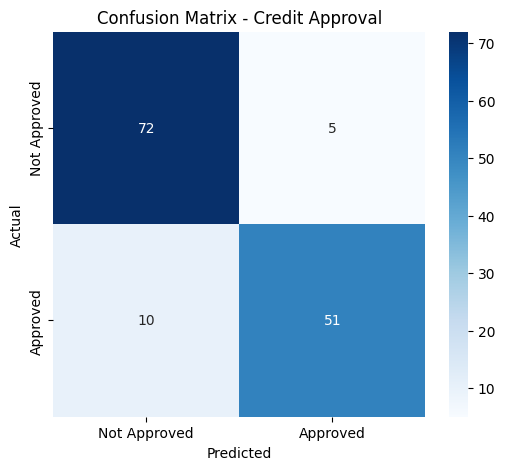

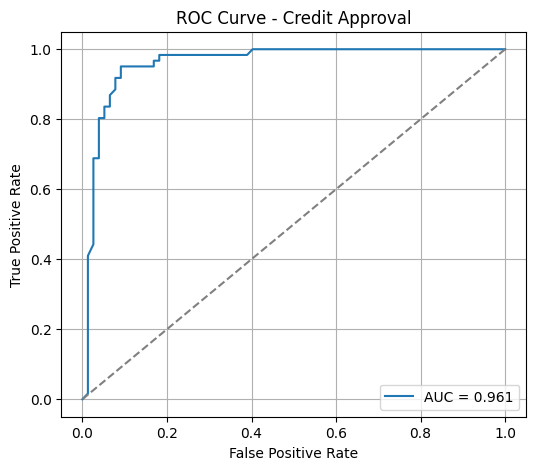

/tmp/ipython-input-3720943089.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=fi_df, palette="viridis")


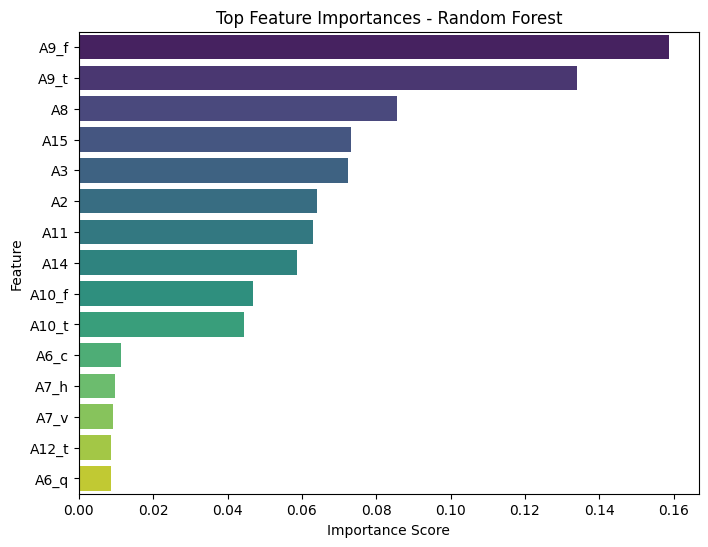

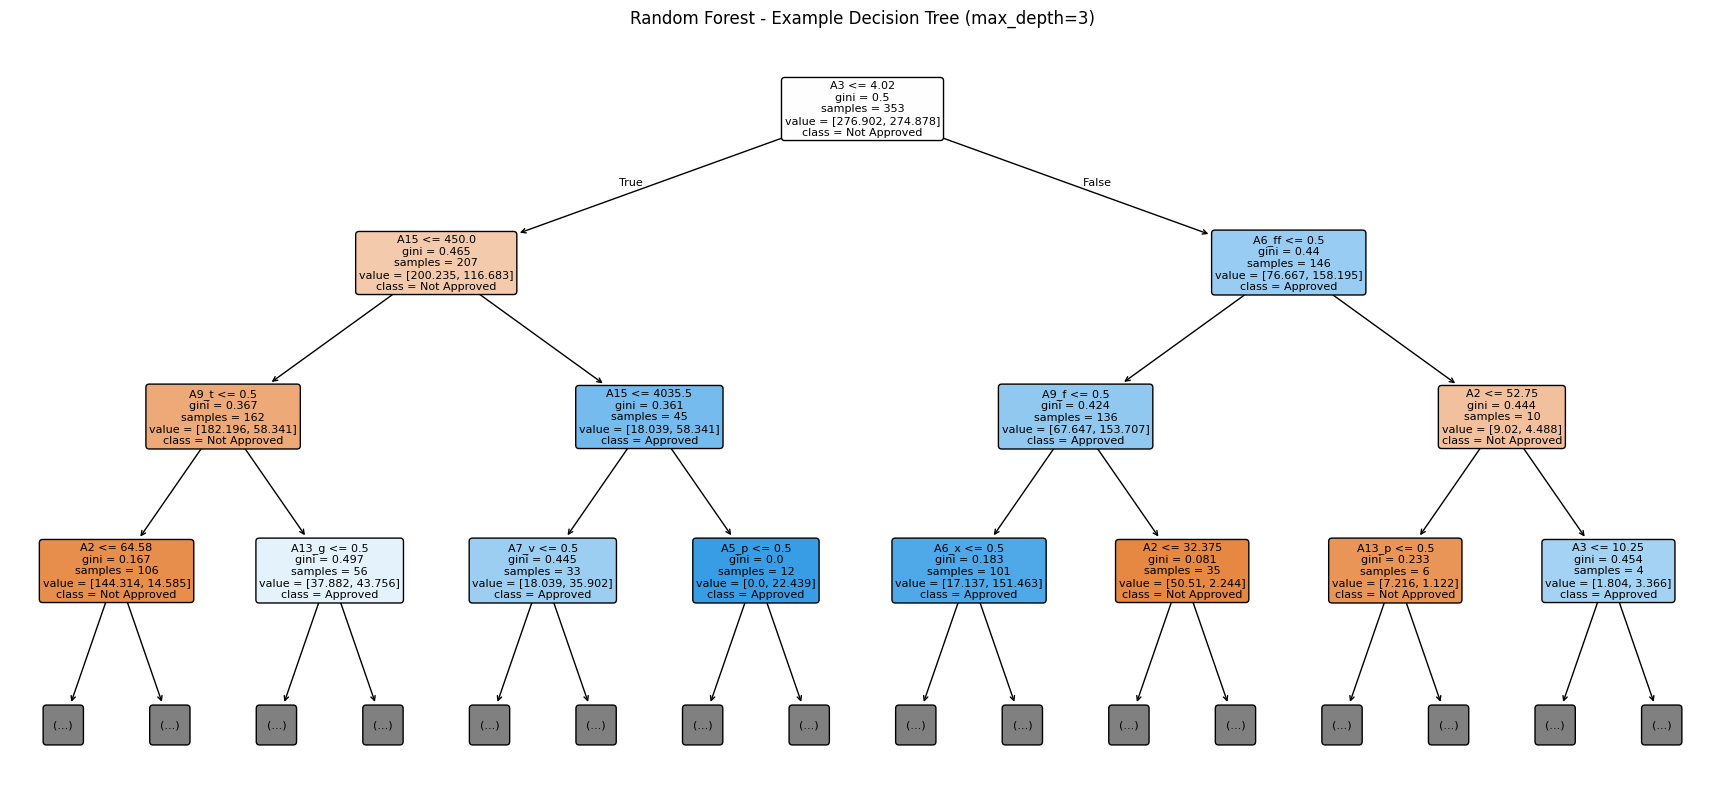

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
from sklearn import tree
import seaborn as sns


data_path = "crx.data"

column_names = [
    "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8",
    "A9", "A10", "A11", "A12", "A13", "A14", "A15", "Class"
]

df = pd.read_csv(
    data_path,
    header=None,
    names=column_names,
    na_values="?"
)

df = df.dropna(subset=["Class"])
df["Class"] = df["Class"].map({"+": 1, "-": 0})

X = df.drop("Class", axis=1)
y = df["Class"]

numeric_features = ["A2", "A3", "A8", "A11", "A14", "A15"]
categorical_features = [col for col in X.columns if col not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", rf_clf)
])

# ---------------- Cross-validation (NEW) ----------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
cv_auc = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")


print(f"Cross-Validation Scores: {cv_acc}")
print(f"Accuracy: mean={cv_acc.mean():.4f}, std={cv_acc.std():.4f}")
print(f"ROC-AUC:  mean={cv_auc.mean():.4f}, std={cv_auc.std():.4f}")

print("-" * 50)

# ---------------- Train / Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Hold-out Test Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Approved", "Approved"],
            yticklabels=["Not Approved", "Approved"])
plt.title("Confusion Matrix - Credit Approval")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------- ROC Curve ----------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Credit Approval")
plt.legend()
plt.grid(True)
plt.show()

# ---------------- Feature Importance ----------------
rf = model.named_steps["classifier"]
ohe = model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]

cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_names])

importances = rf.feature_importances_

fi_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .head(15)
)

plt.figure(figsize=(8, 6))
sns.barplot(x="importance", y="feature", data=fi_df, palette="viridis")
plt.title("Top Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# ---------------- Tree Visualization ----------------
estimator = rf.estimators_[0]

plt.figure(figsize=(22, 10))
tree.plot_tree(
    estimator,
    feature_names=feature_names,
    class_names=["Not Approved", "Approved"],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=8
)
plt.title("Random Forest - Example Decision Tree (max_depth=3)")
plt.show()


In [6]:
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV

print("F1 (binary):", f1_score(y_test, y_pred))

param_grid = {
    "classifier__n_estimators": [100, 200, 400],
    "classifier__max_depth": [None, 10, 20, 40],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["sqrt", "log2"]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("\n====================")
print("GRID SEARCH RESULTS")
print("====================")
print("Best parameters:", grid_search.best_params_)
print("Best CV F1 score:", grid_search.best_score_)


F1 (binary): 0.8717948717948718
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

GRID SEARCH RESULTS
Best parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 400}
Best CV F1 score: 0.857745558830997


In [7]:
best_model = grid_search.best_estimator_

y_pred_tuned = best_model.predict(X_test)
y_proba_tuned = best_model.predict_proba(X_test)[:, 1]

print("\n====================")
print("TUNED MODEL METRICS")
print("====================")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_tuned))
print("F1 (binary):", f1_score(y_test, y_pred_tuned))
print("F1 (macro):", f1_score(y_test, y_pred_tuned, average="macro"))
print("F1 (weighted):", f1_score(y_test, y_pred_tuned, average="weighted"))
print("\nClassification Report (Tuned):\n")
print(classification_report(y_test, y_pred_tuned))


TUNED MODEL METRICS
Accuracy: 0.9057971014492754
ROC-AUC: 0.9623163721524377
F1 (binary): 0.8925619834710744
F1 (macro): 0.9043455078645695
F1 (weighted): 0.9057117135913516

Classification Report (Tuned):

              precision    recall  f1-score   support

           0       0.91      0.92      0.92        77
           1       0.90      0.89      0.89        61

    accuracy                           0.91       138
   macro avg       0.91      0.90      0.90       138
weighted avg       0.91      0.91      0.91       138



In [8]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_tuned)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

best_idx = np.argmax(f1_scores[:-1])
best_threshold = thresholds[best_idx]

y_pred_opt = (y_proba_tuned >= best_threshold).astype(int)

print("\n====================")
print("THRESHOLD OPTIMIZATION")
print("====================")
print("Best threshold:", best_threshold)
print("F1 @ best threshold:", f1_score(y_test, y_pred_opt))


THRESHOLD OPTIMIZATION
Best threshold: 0.4356286669996934
F1 @ best threshold: 0.9133858267716536
